In [57]:
import json
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Preprocess

In [2]:
df = pd.read_parquet("labeled_post.parquet")

## add verdict label

In [3]:
df.link_flair_text.unique()

array(['Not the A-hole', 'Asshole', 'Everyone Sucks', 'Not enough info',
       'No A-holes here', 'Not the A-hole POO Mode', 'Asshole POO Mode',
       'Everyone Sucks POO Mode'], dtype=object)

In [4]:
flairs = {
    'Not the A-hole': 'NTA',
    'Asshole': 'YTA',
    # 'Everyone Sucks': '?'
    # 'Not enough info': '?'
    # 'No A-holes here': '?'
    # 'Not the A-hole POO Mode': 'NTA',
    # 'Asshole POO Mode': 'YTA',
    # 'Everyone Sucks POO Mode': '?'
}

In [5]:
df = df.loc[df.link_flair_text.isin(flairs)].copy()
df['verdict'] = df.link_flair_text.map(flairs)

df["is_asshole"] = 0
df.loc[df.verdict == "YTA", "is_asshole"] = 1

df = df.reset_index().sort_values(by="index")

In [6]:
len(df)

71768

## load enriched data

In [7]:
df_feat = pd.read_parquet("labeled_post_features.parquet")[[
    'id',
    'demonyms',
    'demonyms_words_count',
    'demonyms_unique_count',
    'features',
    'title_uppercase_count',
    'title_word_count',
    'title_profanity_count',
    'avg_word_length',
    'stop_word_count',
    'numerics_count',
    'uppercase_words_count',
    'sentence_count',
    'avg_sentence_length',
    'profanity_count',
]]

## add gender and age

In [8]:
df_llama = pd.concat([
    pd.read_parquet("labeled_post_llama_prompt.parquet"),
    pd.read_parquet("labeled_post_llama_prompt2.parquet")
])

llama_output = []
for part in range(1, 6):
    with open(f"llama-genage/results-unknown-10k-part{part}.json") as f:
        llama_output += json.load(f)

for part in range(1, 5):
    with open(f"llama-genage/results-unknown-10k-part2-{part}.json") as f:
        llama_output += json.load(f)

# remove prompt from llama outputs
df_llama['llama_output'] = llama_output
df_llama['llama_gender_age'] = df_llama.apply(
    lambda x: x['llama_output'][len(x['prompt']):], axis=1)

In [9]:
len(df_llama)

80530

In [10]:
def parse_llama_gender_age(gender_age):
    if ',' not in gender_age:
        return None, None

    s = gender_age.split(',')
    age_raw = s[0].strip()
    gender_raw = s[1].strip().lower()

    age = None
    gender = None
    
    try:
        if 15 < int(age_raw) < 80:
            age = int(age_raw)
        else:
            age = None
    except (ValueError, TypeError):
        age = None

    if gender_raw == "female":
        gender = "F"
    elif gender_raw == "male":
        gender = "M"

    return age, gender


df_llama['llama_age'] = df_llama.llama_gender_age.apply(lambda x: parse_llama_gender_age(x)[0])
df_llama['llama_gender'] = df_llama.llama_gender_age.apply(lambda x: parse_llama_gender_age(x)[1])

In [11]:
df_gen = pd.read_parquet("labeled_post_genage.parquet")[["id", "link_flair_text", "gender", "age"]]
df_gen = df_gen.merge(df_llama[["id", "llama_gender", "llama_age"]], left_on="id", right_on="id")
df_gen = df_gen.loc[df_gen.link_flair_text.isin(flairs)].copy()

In [12]:
# not null rate
len(df_gen.loc[df_gen.gender.notnull()]) / len(df_gen), len(df_gen.loc[df_gen.age.notnull()]) / len(df_gen)

(0.5882287370415784, 0.46223943818972246)

In [13]:
df_gen.loc[df_gen.gender.isna(), 'gender'] = df_gen.llama_gender
df_gen.loc[df_gen.age.isna(), 'age'] = df_gen.llama_age

In [14]:
# not null rate: after comlpement by llama
len(df_gen.loc[df_gen.gender.notnull()]) / len(df_gen), len(df_gen.loc[df_gen.age.notnull()]) / len(df_gen)

(0.6489103778842938, 0.533566492029874)

In [15]:
df_gen.gender = df_gen.gender.fillna("U")
one_hot_encoded = pd.get_dummies(df_gen['gender'], prefix='gender')
df_gen = pd.concat([df_gen, one_hot_encoded], axis=1)

In [16]:
df = df.merge(df_feat, left_on="id", right_on="id")
df = df.merge(df_gen, left_on="id", right_on="id")

## add sentiment

In [20]:
df_sent = pd.read_parquet("labeled_post_sentiment-analysis-pysentimiento.parquet")[["id", "selftext_probas", "title_probas"]]

In [22]:
df_sent_title = df_sent.title_probas.apply(pd.Series).add_prefix("title_")
df_sent = pd.concat([df_sent.drop(columns=['title_probas']), df_sent_title], axis=1)

In [24]:
df_sent_selftext = df_sent.selftext_probas.apply(pd.Series).add_prefix("selftext_")
df_sent = pd.concat([df_sent.drop(columns=['selftext_probas']), df_sent_selftext], axis=1)

In [27]:
df = df.merge(df_sent, left_on="id", right_on="id")

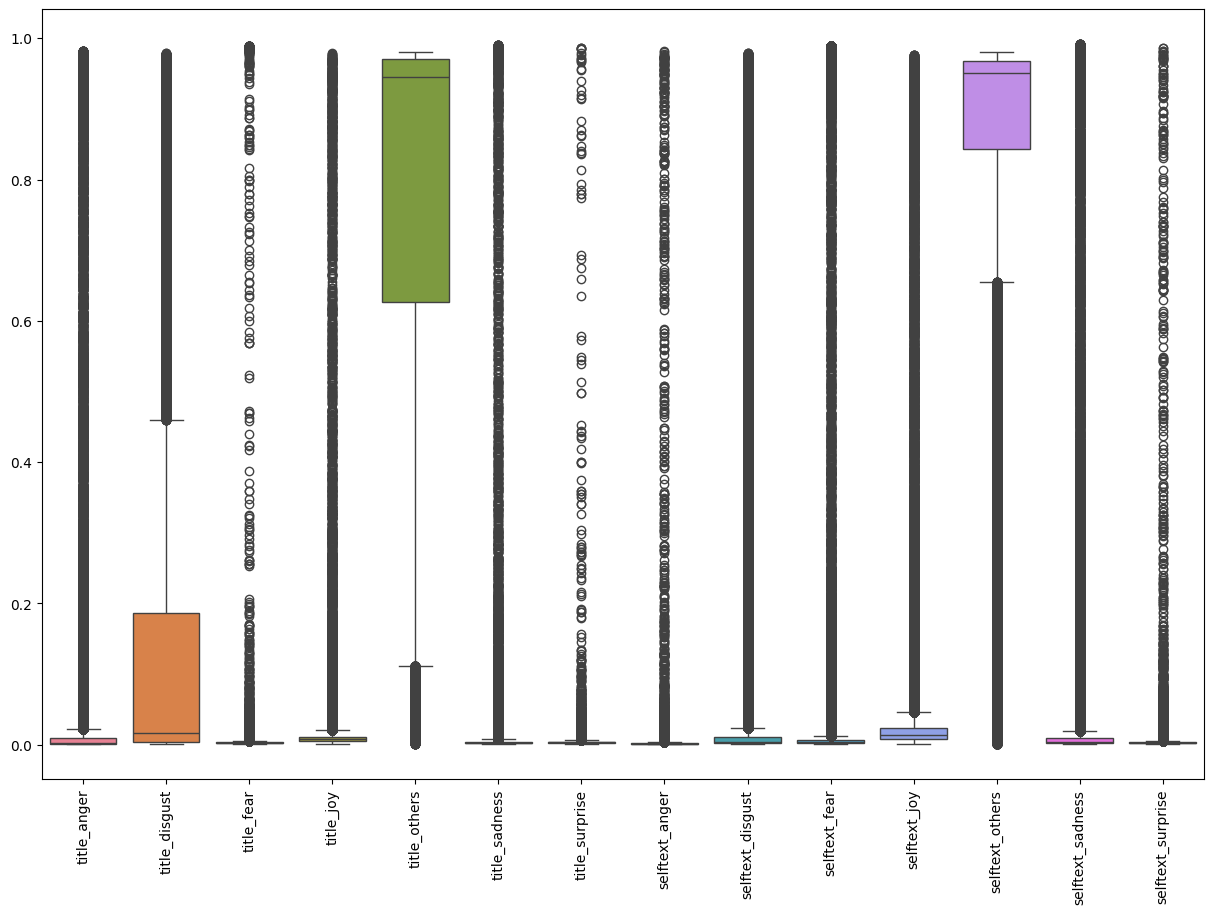

In [58]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_sent)
plt.xticks(rotation=90)
plt.show()

## save

In [28]:
df.to_parquet("labeled_post_enriched.parquet")

# LightGBM

In [29]:
# load processed data
df = pd.read_parquet("labeled_post_enriched.parquet")

In [30]:
min(df.is_asshole.value_counts())

14135

In [31]:
min_samples = min(df.is_asshole.value_counts())
df_use = pd.concat([
    df.loc[df.is_asshole == 0][:min_samples],
    df.loc[df.is_asshole == 1][:min_samples],
])

In [32]:
len(df_use)

28270

In [35]:
X = df_use[[
    # 'index',
    # 'link_flair_text',
    # 'num_comments',
    # 'over_18',
    # 'score',
    # 'url',
    # 'selftext',
    # 'title',
    # 'id',
    # 'edited',
    # 'is_self',
    # 'permalink',
    # 'downs',
    # 'ups',
    # 'created',
    # 'date',
    # 'demonyms',

    # linguistic
    'demonyms_words_count',
    'demonyms_unique_count',
    'title_uppercase_count',
    'title_word_count',
    'title_profanity_count',
    'avg_word_length',
    'stop_word_count',
    'numerics_count',
    'uppercase_words_count',
    'sentence_count',
    'avg_sentence_length',
    'profanity_count',

    # demography
    'age',
    'gender_F',
    'gender_M',
    'gender_U',

    # sentiment
    'title_anger',
    'title_disgust',
    'title_fear',
    'title_joy',
    'title_others',
    'title_sadness',
    'title_surprise',
    'selftext_anger',
    'selftext_disgust',
    'selftext_fear',
    'selftext_joy',
    'selftext_others',
    'selftext_sadness',
    'selftext_surprise',
]].copy()

In [36]:
y = df_use.is_asshole

In [37]:
# full -> train, test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# train -> train, val
# 0.8 x 0.25 = 0.2
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, shuffle=True
)

train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
val_data = lgb.Dataset(X_val, label=y_val, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, free_raw_data=False)

In [38]:
# train_data.save_binary('train.bin')
# val_data.save_binary('val.bin')
# test_data.save_binary('test.bin')

In [39]:
param = {
    'num_leaves': 31,
    'objective': 'binary'
}

In [40]:
num_round = 1000
# bst = lgb.train(param, train_data, num_round, valid_sets=[val_data])
bst = lgb.train(param, train_data, num_round)

[LightGBM] [Info] Number of positive: 8470, number of negative: 8492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4677
[LightGBM] [Info] Number of data points in the train set: 16962, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499351 -> initscore=-0.002594
[LightGBM] [Info] Start training from score -0.002594


In [41]:
# lgb.cv(param, train_data, num_round, nfold=5)

In [42]:
# bst = lgb.train(param, train_data, num_round, valid_sets=valid_sets, callbacks=[lgb.early_stopping(stopping_rounds=5)])

In [43]:
ypred = bst.predict(X_test, num_iteration=bst.best_iteration)

In [44]:
ypred_labels = np.where(ypred >= 0.5, 1, 0)

In [45]:
ypred_labels[:100]

array([0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1])

In [46]:
y_test.values[:100]

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1])

In [47]:
cm = confusion_matrix(y_test, ypred_labels)
TN, FP, FN, TP = cm.ravel()
print(f'True Positives (TP): {TP}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')
print(f'True Negatives (TN): {TN}')

True Positives (TP): 1679
False Positives (FP): 1190
False Negatives (FN): 1149
True Negatives (TN): 1636


In [49]:
print(classification_report(y_test, ypred_labels))

              precision    recall  f1-score   support

           0       0.59      0.58      0.58      2826
           1       0.59      0.59      0.59      2828

    accuracy                           0.59      5654
   macro avg       0.59      0.59      0.59      5654
weighted avg       0.59      0.59      0.59      5654



without sentiment

```
              precision    recall  f1-score   support

           0       0.56      0.57      0.57      2826
           1       0.57      0.56      0.56      2828

    accuracy                           0.57      5654
   macro avg       0.57      0.57      0.57      5654
weighted avg       0.57      0.57      0.57      5654
```

In [50]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)

/Users/thama/Downloads/Reddit/reddit/.venv/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


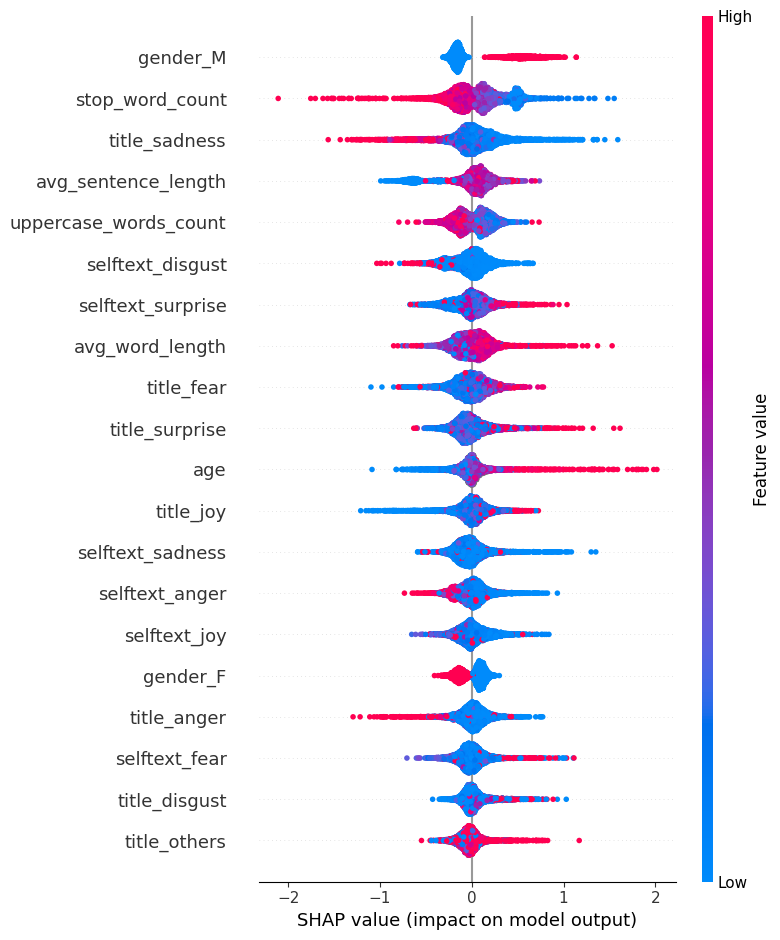

In [51]:
shap.summary_plot(shap_values, X_test)

In [52]:
pivot_table = pd.pivot_table(df[["is_asshole", "gender"]], index='is_asshole', columns='gender', aggfunc=len, fill_value=0)
pivot_table

gender,F,M,U
is_asshole,,,
0,26570,11174,19889
1,4919,3908,5308


In [53]:
df["age_floor"] = df.age.apply(lambda x: (x // 10) * 10)
pivot_table = pd.pivot_table(df[["is_asshole", "age_floor"]], index='is_asshole', columns='age_floor', aggfunc=len, fill_value=0)
pivot_table

age_floor,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0
is_asshole,,,,,,,,,
0,9067,15576,5172,1043,321,83,21,4,17
1,1730,3332,1315,400,146,50,8,3,5


In [54]:
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=0), axis=1) * 100
pivot_table_percentage

age_floor,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0
is_asshole,,,,,,,,,
0,83.977031,82.377829,79.728688,72.279972,68.736617,62.406015,72.413793,57.142857,77.272727
1,16.022969,17.622171,20.271312,27.720028,31.263383,37.593985,27.586207,42.857143,22.727273


In [55]:
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=0), axis=1) * 100
pivot_table_percentage

age_floor,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0
is_asshole,,,,,,,,,
0,83.977031,82.377829,79.728688,72.279972,68.736617,62.406015,72.413793,57.142857,77.272727
1,16.022969,17.622171,20.271312,27.720028,31.263383,37.593985,27.586207,42.857143,22.727273
